In [1]:

import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')
cluster_group_data = pd.read_csv('Data/cluster_group.csv')

general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(cluster_group_data.join(bus_stop_data.join(date_data.join(meta_data))))

from scipy import stats
# set_test = general[['trip_duration_min','trip_length_km']]
# data_set = data_set[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]
# general = general[(np.abs(stats.zscore(set_test)) < 3).all(axis=1)]




general_np = general.to_numpy()

# # filter
# data_set = data_set[np.logical_not(general_np[:, 6] > 10)]
# general_np = general_np[np.logical_not(general_np[:,6] > 10)]
# data_set = data_set[np.logical_not(general_np[:,6] < 0.01)]
# general_np = general_np[np.logical_not(general_np[:,6] < 0.01)]
# data_set = data_set[np.logical_not(general_np[:,5] > 120)]
# general_np = general_np[np.logical_not(general_np[:,5] > 120)]
# data_set = data_set[np.logical_not(general_np[:,5] < 1)]
# general_np = general_np[np.logical_not(general_np[:,5] < 1)]

# data_set = data_set[np.logical_not(np.logical_and(general_np[:, 6] < 0.11, general_np[:, 5] > 20))]
# general_np = general_np[np.logical_not(np.logical_and(general_np[:, 6] < 0.11, general_np[:, 5] > 20))]

Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','end_cluster_group','start_cluster_group','start_date', 'end_near_stop']).to_numpy()

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import progressbar
import cv2 as cv

census_by_community = gpd.read_file('Data/census_by_community1.shp')
grid_data = gpd.read_file('Data/ScooterGridId.shp')
data = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

centeroid_scale_grid = np.array([[x.centroid.x, x.centroid.y] for x in grid_data.geometry])
centeroid_scale_grid[:,0] = centeroid_scale_grid[:,0] + 180
lng_ltd = int(round(max(centeroid_scale_grid[:,0]) - min(centeroid_scale_grid[:,0]), 4) * 100)
lat_ltd = int(round(max(centeroid_scale_grid[:,1]) - min(centeroid_scale_grid[:,1]), 4) * 100)


map_mat = np.zeros((lat_ltd,lng_ltd, 150))

max_lng = max(centeroid_scale_grid[:,0])
max_lat = max(centeroid_scale_grid[:,1])

shape = map_mat.shape

for pos in centeroid_scale_grid:
    for c in range(150):
        pos_lng = abs(int(  ((max_lng - pos[0]))*100  )) - 1
        pos_lat = abs(int(  ((max_lat - pos[1]))*100  )) - 1
        map_mat[pos_lat, pos_lng, c] = 100


map_end = []
for index, row in progressbar.progressbar(data_set.iterrows()):
    for c in range(150):
        if c == row['end_cluster_group']:
            pos_lng = abs(int(  ((max_lng - (row['endx'] + 180) ))*100  )) - 1
            pos_lat = abs(int(  ((max_lat - (row['endy']) ))*100  )) - 1
            map_mat[ pos_lat, pos_lng, c] += 255
            map_end.append(map_mat[:,:, c])
            map_end[index] = np.fliplr(map_end[index])
#             map_end[index] = cv.GaussianBlur(map_end[index],(5,5),0)

            
map_end = np.asarray(map_end)

| |                #                             | 459477 Elapsed Time: 0:06:06


In [3]:

map_end = map_end.reshape(len(map_end),map_end.shape[1],map_end.shape[2],1)

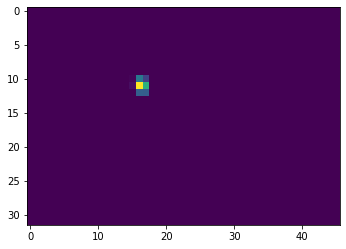

In [4]:
import matplotlib.pyplot as plt

plt.imshow(map_end[1111])

In [5]:


# # max_lng = max(data_set['endx'])
# # max_lat = max(data_set['endy'])

# map_end = []
# for index, row in progressbar.progressbar(data_set.iterrows()):
#     pos_lng = abs(int(  ((max_lng - (row['endx'] + 180) ))*100  )) - 1
#     pos_lat = abs(int(  ((max_lat - (row['endy']) ))*100  )) - 1
#     map_end.append(map_mat.copy())
#     map_end[index][pos_lat, pos_lng] = 255
#     map_end[index] = np.fliplr(map_end[index])
    
# map_end = np.asarray(map_end)    

In [6]:
shape
    

(32, 46, 150)

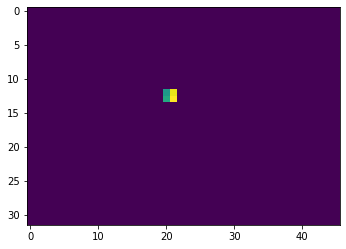

In [7]:
import matplotlib.pyplot as plt

plt.imshow(map_end[67764])

In [8]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scx = MinMaxScaler(feature_range=(0,1))
scy = MinMaxScaler(feature_range=(0,1))
X_data_n = scx.fit_transform(X_data)
Y_data_n = scy.fit_transform(Y_data)

scmap_end = MinMaxScaler(feature_range=(0,1))
map_end_ascolumns = map_end.reshape(len(map_end), -1)
map_end_n = scmap_end.fit_transform(map_end_ascolumns)
# map_end_n = tmap_end.reshape(map_end.shape)

x_train, x_test, y_train, y_test = train_test_split(X_data_n, Y_data_n, test_size=0.4, shuffle=False)
map_end_train = map_end_n[0:len(x_train)]
map_end_test = map_end_n[len(x_train):]

In [37]:
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
inputA = layers.Input(shape=(4))
inputB = layers.Input(shape=(60))

x = Dense(15)(inputA)
x = Dense(30, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
y = Dense(62)(inputB)
y = Dense(70, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)

combined = layers.concatenate([x.output, y.output])

final = Dense(55)(combined)



# inputMap = layers.Input(shape=(shape[0],shape[1],1))
# mapx = Conv2D(filters=32, kernel_size=(4,4), input_shape=(shape[0],shape[1]), activation='relu',)(inputMap)
# mapx = Flatten()(mapx)
# mapx = Model(inputs=inputMap, outputs=mapx)


image = Dense(map_end_n.shape[1])(final)

# inputMap = tf.keras.layers.Reshape((map_end.shape[1], map_end.shape[2], 1))(image_n)
# mapx = Conv2D(filters=32, kernel_size=(4,4), input_shape=(shape[0],shape[1]), activation='relu')(inputMap)
# mapx = Flatten()(mapx)

# image = Dense(map_end_n.shape[1], activation='relu')(mapx)

# xx = Dense(15)(inputA)
# xx = Dense(64, activation="relu")(xx)
# xx = Model(inputs=inputA, outputs=xx)

# yy = Dense(62)(inputB)
# yy = Dense(64, activation="relu")(yy)
# yy = Model(inputs=inputB, outputs=yy)


# combined_twoa = layers.concatenate([xx.output, yy.output])


# xi = Dense(29)(image)
# xi = Dense(30, activation="relu")(xi)
# combined_twob = layers.concatenate([combined_twoa, image])
# combinedb = layers.concatenate([combined, image])
# final_two = Dense(55, activation="softmax")(combined)
a = Dense(2)(final)
# rea = layers.concatenate([final, mapx.output])
# a = Dense(2)(rea)

model = Model(inputs=[x.input,y.input], outputs=[a,image])
model.summary()

ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 15]

In [33]:
from tensorflow.python.keras.callbacks import EarlyStopping

model.compile(loss="mean_absolute_error", optimizer="adam")

callback = EarlyStopping(monitor='loss', patience=5, mode="auto")
# history = model.fit([x_train[:,0:7],x_train[:,7:]], [y_train[:,0:2], y_train[:,2:4]], epochs=100, validation_data=([x_test[:,0:7],x_test[:,7:]], [y_test[:,0:2], y_test[:,2:4]]))

history = model.fit([x_train[:,0:4],x_train[:,4:]], [y_train, map_end_train], epochs=50)

Epoch 1/50
275686/275686 [==============================] - 18s 64us/sample - loss: 0.0242 - dense_18_loss: 0.0210 - dense_17_loss: 0.0033
Epoch 2/50
275686/275686 [==============================] - 14s 51us/sample - loss: 0.0225 - dense_18_loss: 0.0195 - dense_17_loss: 0.0030
Epoch 3/50
275686/275686 [==============================] - 13s 48us/sample - loss: 0.0222 - dense_18_loss: 0.0193 - dense_17_loss: 0.0029
Epoch 4/50
275686/275686 [==============================] - 13s 48us/sample - loss: 0.0220 - dense_18_loss: 0.0191 - dense_17_loss: 0.0029
Epoch 5/50
275686/275686 [==============================] - 14s 50us/sample - loss: 0.0219 - dense_18_loss: 0.0190 - dense_17_loss: 0.0029
Epoch 6/50
275686/275686 [==============================] - 13s 49us/sample - loss: 0.0217 - dense_18_loss: 0.0189 - dense_17_loss: 0.0028
Epoch 7/50
275686/275686 [==============================] - 13s 49us/sample - loss: 0.0217 - dense_18_loss: 0.0189 - dense_17_loss: 0.0028
Epoch 8/50
275686/275686 [=

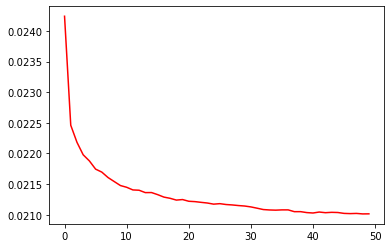

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='r')
plt.show()

In [36]:
model.evaluate([x_test[:,0:4],x_test[:,4:]], [y_test, map_end_test])

183792/183792 [==============================] - 6s 33us/sample - loss: 0.0209 - dense_18_loss: 0.0183 - dense_17_loss: 0.0026


[0.020885017798838796, 0.018280221, 0.0026046133]

In [18]:
result = model.predict([x_test[:,0:4],x_test[:,4:]])

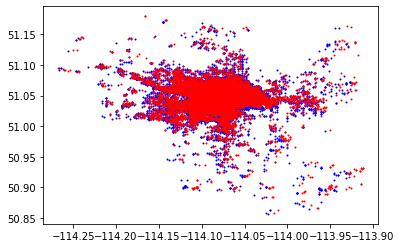

In [24]:
import matplotlib.pyplot as plt
import numpy as np
result = model.predict([x_test[:,0:4],x_test[:,4:]])

result_Y = result
result_Y_plot = scy.inverse_transform(result_Y)
y_test_plot = scy.inverse_transform(y_test)

plt.scatter((y_test_plot[:,0]),(y_test_plot[:,1]), color='b', s= 1)
plt.scatter((result_Y_plot[:,0]), (result_Y_plot[:,1]), color='r', s= 1)



In [25]:
result_map = result[1]
result_map = scmap_end.inverse_transform(result_map)
result_map = result_map.reshape((len(map_end_test), map_end.shape[1], map_end.shape[2]))
# result[1].reshape(map_end.shape)


ValueError: Expected 2D array, got 1D array instead:
array=[0.5785528 0.5798894].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [26]:
import matplotlib.pyplot as plt
# scmap_end.fit_transform(map_end_ascolumns)
plt.imshow(result_map[39950])

IndexError: index 39950 is out of bounds for axis 0 with size 2

In [27]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

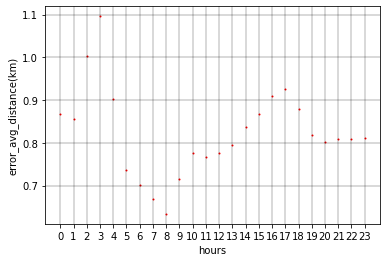

In [28]:
mae_rate_hour = []

x_test_hour = scx.inverse_transform(x_test)

result_Y_hour = scy.inverse_transform(result_Y)
y_test_hour = scy.inverse_transform(y_test)
for index in range(24):
    mask = np.logical_and(x_test_hour[:,3] > (index)-0.2, x_test_hour[:,3] < (index+1)-0.2)
    result_Y_d = result_Y_hour[mask]
    Y_test_in = y_test_hour[mask]
    error = 0
    for i in range(len(Y_test_in)):
        error = error + haversine(result_Y_d[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_hour.append([float(error_average_distance), str(index)])

mae_rate_hour = np.array(mae_rate_hour, dtype=np.object)
plt.xlabel('hours')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_hour[:,1], mae_rate_hour[:,0], color='r', s= 1)


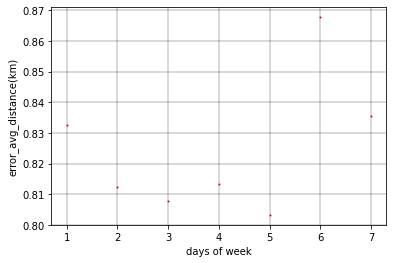

In [29]:
mae_rate_day_of_week = []

x_test_day = scx.inverse_transform(x_test)
x
result_Y_day = scy.inverse_transform(result_Y)
y_test_day = scy.inverse_transform(y_test)
for index in range(7):
    mask = np.logical_and(x_test_day[:,4] > (index)-0.1, x_test_day[:,4] < (index+1)-0.1)
    result_Y_d_day = result_Y_day[mask]
    Y_test_in = y_test_day[mask]
    error = 0
    haverList = []
    for i in (range(len(Y_test_in))):
        error = error + haversine(result_Y_d_day[i,0:2],Y_test_in[i,0:2])
    end = error/len(Y_test_in)
    error_average_distance = end

    y_test[:,0] = y_test[:,0]
    mae_rate_day_of_week.append([error_average_distance, str(index+1)])

mae_rate_day_of_week = np.array(mae_rate_day_of_week, dtype=np.object)
plt.xlabel('days of week')
plt.ylabel('error_avg_distance(km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(mae_rate_day_of_week[:,1], mae_rate_day_of_week[:,0], color='r', s= 1)

In [30]:
result_Y_all = scy.inverse_transform(result_Y)
y_test_all = scy.inverse_transform(y_test)
error_all = 0
for i in (range(len(y_test_all))):
    error_all = error_all + haversine(result_Y_all[i],y_test_all[i])
    error_avg = error_all/len(y_test_all)
error_avg

0.8246943352811903